In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../..')

from court_decision_prediction.utils import *

# 1. Overview

In [2]:
data = pd.read_csv(PATH.train)
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2478 entries, 0 to 2477
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ID                  2478 non-null   object
 1   first_party         2478 non-null   object
 2   second_party        2478 non-null   object
 3   facts               2478 non-null   object
 4   first_party_winner  2478 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 96.9+ KB


,ID,first_party,second_party,facts,first_party_winner
0,TRAIN_0000,Phil A. St. Amant,Herman A. Thompson,"On June 27, 1962, Phil St. Amant, a candidate for public office, made a television speech in Baton Rouge, Louisiana. During this speech, St. Amant accused his political opponent of being a Communist and of being involved in criminal activities with the head of the local Teamsters Union. Finally, St. Amant implicated Herman Thompson, an East Baton Rouge deputy sheriff, in a scheme to move money between the Teamsters Union and St. Amant’s political opponent. \nThompson successfully sued St. Amant for defamation. Louisiana’s First Circuit Court of Appeals reversed, holding that Thompson did not show St. Amant acted with “malice.” Thompson then appealed to the Supreme Court of Louisiana. That court held that, although public figures forfeit some of their First Amendment protection from defamation, St. Amant accused Thompson of a crime with utter disregard of whether the remarks were true. Finally, that court held that the First Amendment protects uninhibited, robust debate, rathe...",1
1,TRAIN_0001,Stephen Duncan,Lawrence Owens,"Ramon Nelson was riding his bike when he suffered a lethal blow to the back of his head with a baseball bat. After two eyewitnesses identified Lawrence Owens from an array of photos and then a lineup, he was tried and convicted for Nelson’s death. Because Nelson was carrying cocaine and crack cocaine potentially for distribution, the judge at Owens’ bench trial ruled that Owens was probably also a drug dealer and was trying to “knock [Nelson] off.” Owens was found guilty of first-degree murder and sentenced to 25 years in prison.\nOwens filed a petition for a writ of habeas corpus on the grounds that his constitutional right to due process was violated during the trial. He argued that the eyewitness identification should have been inadmissible based on unreliability and that the judge impermissibly inferred a motive when a motive was not an element of the offense. The district court denied the writ of habeas corpus, and Owens appealed. The U.S. Court of Appeals for the Seventh Circ...",0
2,TRAIN_0002,Billy Joe Magwood,"Tony Patterson, Warden, et al.","An Alabama state court convicted Billy Joe Magwood of murder and sentenced him to death. Subsequently, an Alabama federal district court partially granted Mr. Magwood's petition for federal habeas corpus relief. The court upheld his conviction but instructed the state court to look at mitigating evidence when resentencing Mr. Magwood. Upon resentencing, the state court sentenced Mr. Magwood to death once again. Mr. Magwood filed a second petition for federal habeas corpus relief with the federal district court arguing that a judicial rule was retroactively applied in his case and that he lacked effective counsel at sentencing. The district court granted the petition and vacated Mr. Magwood's death sentence.\nOn appeal, the U.S. Court of Appeals for the Eleventh circuit reversed, holding that prisoners may not raise challenges to an original sentence that could have been raised in an earlier petition. The court also held that Mr. Magwood's counsel was not ineffective because he fail...",1
3,TRAIN_0003,Linkletter,Walker,"Victor Linkletter was convicted in state court on evidence illegally obtained by police prior to the Supreme Court decision concerning the Fourth Amendment in Mapp v. Ohio. Mapp applied the exclusionary rule to state criminal proceedings, denying the use of illegally obtained evidence at trial. Linkletter argued for a retrial based on the Mapp decision.\n",0
4,TRAIN_0004,William Earl Fikes,Alabama,"On April 24, 1953 in Selma, Alabama, an intruder broke into the apartment of the daughter of the city mayor. The daughter and the intruder struggled through several rooms until she was able to seize his knife, and he fled. The assailant had a towel over his head, so the victim could not identify the defendant during the trial. The police apprehend

# 2. `party` vs `first_party_winner`

In [3]:
fp, sp = data['first_party'], data['second_party']
target = data['first_party_winner']

first_party_winner
1    1649
0     829
Name: count, dtype: int64
0.66545601291364


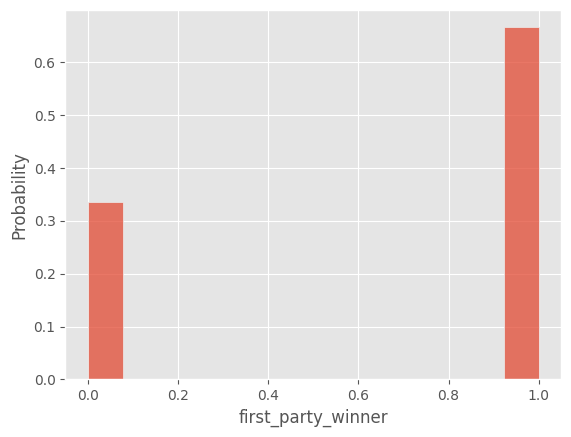

In [4]:
target_mean_global = target.mean()

print(target.value_counts())
print(target_mean_global)
sns.histplot(target, stat='probability');

- Unbalanced target \
`target=1` 약 66%

In [5]:
fp.value_counts().to_frame().head(20).T

first_party,United States,Illinois,Maryland,Florida,New York,United States of America,Michigan,California,Federal Election Commission,Arizona,National Association for the Advancement of Colored People,Johnson,Immigration and Naturalization Service,Mitchell,Washington,Brown,Smith,Reno,Pennsylvania,Harris
count,154,9,8,8,7,7,7,7,5,5,5,5,4,4,4,4,4,4,4,4


In [6]:
sp.value_counts().to_frame().head(20).T

second_party,United States,California,United States of America,Illinois,Federal Communications Commission,Florida,Louisiana,Texas,New York,Georgia,Arizona,North Carolina,National Labor Relations Board,Michigan,Commissioner of Internal Revenue,Maryland,Alabama,Doe,Washington,Securities and Exchange Commission
count,240,19,15,13,10,10,9,9,8,8,7,7,6,6,6,6,6,5,5,5


- `party`에는 `Uited States`가 가장 많고, 동일 대상을 지칭하는 여러 단어들을 통합할 필요가 있음
- `united states`, `states`, `other`로 나누어보고, `other`를 좀 더 세분화할 필요가 있음

In [115]:
states = list(map(str.lower, ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']))
cities = ['new york', 'los angeles', 'chicago', 'houston', 'phoenix', 'philadelphia', 'san antonio', 'san diego', 'dallas', 'san francisco', 'oakland', 'austin', 'jacksonville', 'san jose', 'california', 'indianapolis', 'seattle', 'denver', 'washington', 'boston', 'el paso', 'nashville', 'detroit', 'oklahoma', 'portland', 'las vegas', 'memphis', 'louisville', 'baltimore', 'milwaukee', 'albuquerque', 'tucson', 'fresno', 'mesa', 'sacramento', 'atlanta', 'kansas city', 'colorado springs', 'omaha', 'raleigh', 'miami', 'long beach', 'virginia beach', 'oakland', 'minneapolis', 'tulsa', 'tampa', 'arlington', 'new orleans', 'wichita', 'cleveland', 'bakersfield', 'aurora', 'anaheim', 'honolulu', 'santa ana', 'riverside', 'corpus christi', 'lexington', 'stockton', 'anchorage', 'st. paul', 'newark', 'buffalo', 'plano', 'henderson', 'fort wayne', 'greensboro', 'lincoln', 'glendale', 'chandler', 'st. petersburg', 'jersey city', 'scottsdale', 'norfolk', 'madison', 'orlando', 'birmingham', 'baton rouge', 'durham', 'laredo', 'garland', 'chula vista', 'riverside', 'hialeah', 'lubbock', 'reno', 'north las vegas', 'akron', 'gilbert', 'rochester', 'boise', 'spokane']

In [8]:
def generate_fn(col):
    def fn(row):
        party = row[col].lower()
        
        # 1. Check US
        if ('united states' in party) or ('federal' in party):
            return 'united states'
        else:
            # 2. Check state
            for state in states:
                if state in party:
                    return 'state'
        return 'other'
    return fn
    
data['first_party_grp']  = data.apply(generate_fn('first_party'), axis=1)
data['second_party_grp'] = data.apply(generate_fn('second_party'), axis=1)

In [9]:
data.head()

,ID,first_party,second_party,facts,first_party_winner,first_party_grp,second_party_grp
0,TRAIN_0000,Phil A. St. Amant,Herman A. Thompson,"On June 27, 1962, Phil St. Amant, a candidate for public office, made a television speech in Baton Rouge, Louisiana. During this speech, St. Amant accused his political opponent of being a Communist and of being involved in criminal activities with the head of the local Teamsters Union. Finally, St. Amant implicated Herman Thompson, an East Baton Rouge deputy sheriff, in a scheme to move money between the Teamsters Union and St. Amant’s political opponent. \nThompson successfully sued St. Amant for defamation. Louisiana’s First Circuit Court of Appeals reversed, holding that Thompson did not show St. Amant acted with “malice.” Thompson then appealed to the Supreme Court of Louisiana. That court held that, although public figures forfeit some of their First Amendment protection from defamation, St. Amant accused Thompson of a crime with utter disregard of whether the remarks were true. Finally, that court held that the First Amendment protects uninhibited, robust debate, rathe...",1,other,other
1,TRAIN_0001,Stephen Duncan,Lawrence Owens,"Ramon Nelson was riding his bike when he suffered a lethal blow to the back of his head with a baseball bat. After two eyewitnesses identified Lawrence Owens from an array of photos and then a lineup, he was tried and convicted for Nelson’s death. Because Nelson was carrying cocaine and crack cocaine potentially for distribution, the judge at Owens’ bench trial ruled that Owens was probably also a drug dealer and was trying to “knock [Nelson] off.” Owens was found guilty of first-degree murder and sentenced to 25 years in prison.\nOwens filed a petition for a writ of habeas corpus on the grounds that his constitutional right to due process was violated during the trial. He argued that the eyewitness identification should have been inadmissible based on unreliability and that the judge impermissibly inferred a motive when a motive was not an element of the offense. The district court denied the writ of habeas corpus, and Owens appealed. The U.S. Court of Appeals for the Seventh Circ...",0,other,other
2,TRAIN_0002,Billy Joe Magwood,"Tony Patterson, Warden, et al.","An Alabama state court convicted Billy Joe Magwood of murder and sentenced him to death. Subsequently, an Alabama federal district court partially granted Mr. Magwood's petition for federal habeas corpus relief. The court upheld his conviction but instructed the state court to look at mitigating evidence when resentencing Mr. Magwood. Upon resentencing, the state court sentenced Mr. Magwood to death once again. Mr. Magwood filed a second petition for federal habeas corpus relief with the federal district court arguing that a judicial rule was retroactively applied in his case and that he lacked effective counsel at sentencing. The district court granted the petition and vacated Mr. Magwood's death sentence.\nOn appeal, the U.S. Court of Appeals for the Eleventh circuit reversed, holding that prisoners may not raise challenges to an original sentence that could have been raised in an earlier petition. The court also held that Mr. Magwood's counsel was not ineffective because he fail...",1,other,other
3,TRAIN_0003,Linkletter,Walker,"Victor Linkletter was convicted in state court on evidence illegally obtained by police prior to the Supreme Court decision concerning the Fourth Amendment in Mapp v. Ohio. Mapp applied the exclusionary rule to state criminal proceedings, denying the use of illegally obtained evidence at trial. Linkletter argued for a retrial based on the Mapp decision.\n",0,other,other
4,TRAIN_0004,William Earl Fikes,Alabama,"On April 24, 1953 in Selma, Alabama, an intruder broke into the apartment of the daughter of the city mayor. The daughter and the intruder struggled through several rooms until she was able to seize his knife, and he fled. The assailant had a towel over his head, so t

In [43]:
data['grp'] = list(zip(data['first_party_grp'], data['second_party_grp']))
data['grp'] = data['grp'].astype('string')

In [34]:
parties_grp = pd.concat([data['first_party_grp'], data['second_party_grp']], ignore_index=True)
parties_grp.value_counts()

other            3683
state             755
united states     518
Name: count, dtype: int64

- `other`가 너무 많아서 좀 나누고 싶다. us, state인데 other로 잘못 분류된 친구들이라던지, 기업이라던지

In [64]:
parties = pd.concat([data['first_party'], data['second_party']], ignore_index=True)
parties.value_counts()

United States                 394
California                     26
Illinois                       22
United States of America       22
Florida                        18
                             ... 
Seling                          1
Kalman J. Berenyi               1
Sally L. Conkright, et al.      1
Miranda                         1
Westview Instruments, Inc.      1
Name: count, Length: 3956, dtype: int64

In [69]:
parties_concat = pd.concat([parties, parties_grp], axis=1, keys=['party', 'party_grp'])
parties_concat

,party,party_grp
0,Phil A. St. Amant,other
1,Stephen Duncan,other
2,Billy Joe Magwood,other
3,Linkletter,other
4,William Earl Fikes,other
...,...,...
4951,"Renewable Fuels Association, et al.",other
4952,"Alliance Bond Fund, Inc.",other
4953,United States,united states
4954,St. Cyr,other


In [73]:
parties_other = parties_concat[parties_concat['party_grp'] == 'other'][['party']]
parties_other

,party
0,Phil A. St. Amant
1,Stephen Duncan
2,Billy Joe Magwood
3,Linkletter
4,William Earl Fikes
...,...
4950,Cuauhtemoc Gonzalez-Lopez
4951,"Renewable Fuels Association, et al."
4952,"Alliance Bond Fund, Inc."
4954,St. Cyr


In [84]:
parties_other.value_counts().to_frame().head(10)

,count
party,
National Labor Relations Board,9
Securities and Exchange Commission,8
Commissioner of Internal Revenue,8
Johnson,8
Davis,7
Jones,6
Lewis,6
Brown,6
Williams,6


In [83]:
parties_other.value_counts().to_frame()

,count
party,
National Labor Relations Board,9
Securities and Exchange Commission,8
Commissioner of Internal Revenue,8
Johnson,8
Davis,7
...,...
Garrison,1
Gary Bradford Cone,1
Gary E. Widmar,1


- 좀 더 자세히 나눌 수 있을 것 같다.
    - 'united states': 'Commision', 'Commodity'
    - 'state': 'School Board', 'City'
    - 'group1': 'Corporation', 'Inc', 'Company', 'Bank', 'Association', 'Republic', 'LLC', 'Co.'
    - 'group2': , (쉼표)
    - 'indiv': 나머지

In [154]:
def append_party_group(data):
    def generate_fn(col):
        def fn(row):
            party = row[col].lower()

            keywords1 = ['united states', 'federal', 'commision', 'commodity', 'national']
            keywords2 = states + cities + ['school board', 'city', 'republic', 'region', 'district', 'county']
            keywords3 = ['corporation', 'inc', 'company', 'bank', 'association', 'llc', 'co.', 'hospital', 'usa', 'school', 'group', 'office', 'department']
            keywords4 = [',', 'et al']

            for grp, keywords in zip(['united states', 'states', 'group1', 'group2'],
                                    [keywords1, keywords2, keywords3, keywords4]):
                for key in keywords:
                    if key in party:
                        return grp
            return 'indiv'
        return fn

    data['first_party_grp']  = data.apply(generate_fn('first_party'), axis=1)
    data['second_party_grp'] = data.apply(generate_fn('second_party'), axis=1)    


data = pd.read_csv(PATH.train)
append_party_group(data)

In [155]:
parties     = pd.concat([data['first_party'], data['second_party']], ignore_index=True)
parties_grp = pd.concat([data['first_party_grp'], data['second_party_grp']], ignore_index=True)
parties_concat = pd.concat([parties, parties_grp], axis=1, keys=['party', 'party_grp'])
parties_concat['party_grp'].value_counts().to_frame()

,count
party_grp,
indiv,1973
states,984
group1,713
group2,683
united states,603


In [156]:
parties_concat[parties_concat['party_grp'] == 'indiv'].head(10)

,party,party_grp
0,Phil A. St. Amant,indiv
1,Stephen Duncan,indiv
2,Billy Joe Magwood,indiv
3,Linkletter,indiv
4,William Earl Fikes,indiv
9,Paul A. McDaniel,indiv
16,Plyler,indiv
17,Steven Spears,indiv
20,Clay,indiv
21,Bassam Yacoub Salman,indiv


---

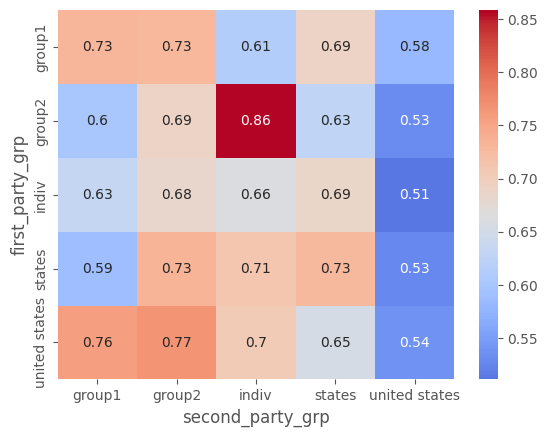

In [157]:
conf = data.pivot_table(index='first_party_grp', columns='second_party_grp', values='first_party_winner')
sns.heatmap(conf, annot=True, center=target_mean_global, cmap='coolwarm');

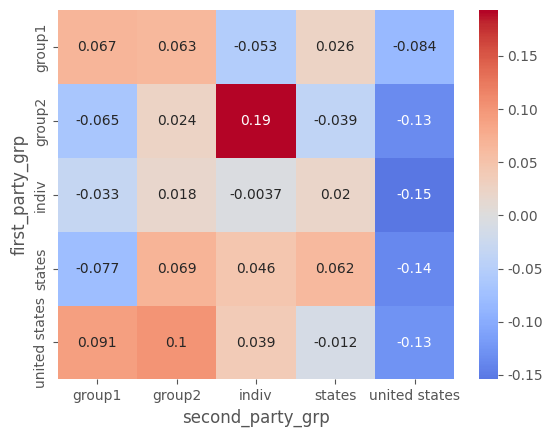

In [158]:
sns.heatmap(conf - target_mean_global, cmap='coolwarm', center=0, annot=True);

- 3개 pair가 가장 눈에 띤다.
    - (group2, indiv)
    - (united states, group2)
    - (indiv, united states)

In [159]:
select = lambda grp1, grp2: data[(data['first_party_grp'] == grp1) & (data['second_party_grp'] == grp2)]
pair1 = select('group2', 'indiv')
pair2 = select('united states', 'group2')
pair3 = select('indiv', 'united states')

In [160]:
len(pair1), len(pair2), len(pair3)

(92, 30, 225)

In [161]:
pair1

,ID,first_party,second_party,facts,first_party_winner,first_party_grp,second_party_grp
8,TRAIN_0008,"Ron Davis, Acting Warden",Hector Ayala,"Hector Ayala, a Hispanic man, was charged with three counts of murder and one count of attempted murder stemming from a failed robbery. During jury selection for his trial in California state court, the prosecution used seven preemptory challenges to exclude each black or Hispanic prospective juror. Ayala challenged the prosecution's use of preemptory challenges as a violation of the Supreme Court's decision in Batson v. Kentucky, which held that the exclusion of jurors on the basis of race was a violation of the Equal Protection Clause of the Fourteenth Amendment. In accordance with Batson, if a party can make a prima facie showing that preemptory challenges are being used in a racially motivated way, the other party must give a non-racially motivated reason for their use of the preemptory challenges. The state court allowed the prosecution to give their non-racially motivated reasons in a closed hearing, from which Ayala and his attorneys were excluded, and subsequently found the...",1,group2,indiv
24,TRAIN_0024,Charles Wilkie et al.,Harvey Frank Robbins,"Harvey Robbins owned a private dude ranch which was intermingled with federal lands. The previous owner had granted the Bureau of Land Management (BLM) right-of-way across the private land, but after Robbins bought the ranch he refused to re-grant it. Robbins alleged that BLM officials harassed him with threats and meritless criminal charges, with the aim of forcing him to grant the government right-of-way. Robbins sued the BLM officials for extortion in violation of the Racketeer Influenced and Corrupt Organizations Act (RICO). He also brought a Bivens action (an action seeking monetary damages from a federal agent for a constitutional violation). Robbins argued that the Fifth Amendment protects a ""right to exclude"" government officials from one's property, and that the BLM agents had retaliated against him for his exercise of this right. The District Court dismissed both claims, but the U.S. Court of Appeals for the Tenth Circuit reversed. On appeal to the Supreme Court, the gove...",1,group2,indiv
27,TRAIN_0027,"American Express, et al.",Italian Colors Restaurant,"American Express Company provides charge card services to supermarkets and other merchants throughout the United States. When a store decides to accept American Express cards, it must enter into a Card Acceptance Agreement. This standard form contract outlines the basic relationship between American Express and the merchant. A clause within the agreement requires arbitration of all claims brought against American Express and prohibits merchants from bringing any class action claims.\nSeveral merchants, including Italian Colors Restaurant, brought individual lawsuits against American Express, claiming that the Card Acceptance Agreement violates U.S. antitrust laws. The United States District Court for the Southern District of New York consolidated the cases and American Express moved to dismiss in order to force the merchants to arbitrate. The district court enforced the arbitration clause and dismissed the case. The merchants appealed and the United States Court of Appeals for the ...",1,group2,indiv
34,TRAIN_0034,Jeanne S. Woodford et al.,Viet Mike Ngo,"Under the Prison Litigation Reform Act of 1995 (PLRA), prisoners must exhaust any available administrative remedies for resolving disputes within the prison system before they can bring suit in federal court. Viet Mike Ngo filed a grievance with the California prison system, but it was dismissed because he had waited too long to file it. He then brought suit in federal district court. California objected, arguing that he had not exhausted his administrative remedies, and that the fact those remedies were no longer available to him because of his delay in filing was immaterial. The district court agreed, but the Ninth Cir

In [162]:
pair1.values[0][3]

"Hector Ayala, a Hispanic man, was charged with three counts of murder and one count of attempted murder stemming from a failed robbery. During jury selection for his trial in California state court, the prosecution used seven preemptory challenges to exclude each black or Hispanic prospective juror. Ayala challenged the prosecution's use of preemptory challenges as a violation of the Supreme Court's decision in Batson v. Kentucky, which held that the exclusion of jurors on the basis of race was a violation of the Equal Protection Clause of the Fourteenth Amendment. In accordance with Batson, if a party can make a prima facie showing that preemptory challenges are being used in a racially motivated way, the other party must give a non-racially motivated reason for their use of the preemptory challenges. The state court allowed the prosecution to give their non-racially motivated reasons in a closed hearing, from which Ayala and his attorneys were excluded, and subsequently found the pr

1. 헥터 아야라는 히스패닉 남성으로서 캘리포니아 주에서 살인과 살인시도 혐의로 기소되었다.
2. 배심원 선출 절차에서 검찰은 검은 인종과 히스패닉 출신 배심원을 배제하기 위해 예견적 도전을 사용했다.
3. 아야라는 이를 인종적인 차별로 보고 Batson 판결을 인용하여 반박했다.
4. 주 법원은 비공개 회의에서 검찰이 비인종적 동기를 제시할 수 있도록 허용했으며, 검찰의 예견적 도전은 인종적 동기가 아니라고 결정되었다.
5. 아야라와 변호인은 청취회의에서 제외되었고, 회의 내용이나 이유를 알지 못했다.
6. 재판 이후, 배심원 설문지 대부분이 분실된 사실이 밝혀졌다.
7. 캘리포니아 주 최고법원은 상소 절차에서 오류가 있었지만 가벼운 영향을 미쳤으며, 따라서 아야라의 유죄 판결을 유지했다.
8. 아야라는 미국 제9 회로항소법원에 상소하였고, 이는 Batson 청취회의에서 제외된 점과 설문지 손실이 그의 헌법적 권리를 침해했다는 주장이다.

- 죄명에 대한 분류도 있으면 좋을 것 같다

In [163]:
pair2

,ID,first_party,second_party,facts,first_party_winner,first_party_grp,second_party_grp
155,TRAIN_0155,"Federal Republic of Germany, et al.","Alan Philipp, et al.","In 1929, just weeks before the October 1929 global stock market crash, several Jewish art dealers in Germany purchased a collection of medieval reliquaries. During the ensuing global depression, the dealers sold about half the pieces and stored the remainder in the Netherlands. Nazi leaders negotiated with the dealers to buy the remaining pieces; the parties dispute whether this negotiation was made under coercive circumstances. After World War II, the collection was transferred to Stiftung Preussischer Kulturbesitz (“SPK”), a German governmental institution that holds the cultural artifacts of former Prussia, and has been on display in a German museum nearly continuously since then.\nIn 2014, heirs of the Jewish art dealers—respondents in this case—participated in a non-binding mediation process before the Advisory Commission for the Return of Cultural Property Seized as a Result of Nazi Persecution, Especially Jewish Property (the “Advisory Commission”). In what the heirs describ...",1,united states,group2
245,TRAIN_0245,"United States , et al.","B. J. Boyd, Commissioner","In 1955, Tennessee amended a statute that was based on the Atomic Energy Act and allowed the Atomic Energy Commission (AEC) and its contractors to operate without paying sales tax. Under the amended statute, contractors must pay a contractor’s tax, regardless of the source or destination of the product. Union Carbide Corp, H.K. Ferguson Co. — both of which hold AEC contracts — and the AEC sued Tennessee to recover the sales and contractor’s tax.\nThe trial court dismissed the suit due to the existing statute, and the plaintiffs appealed. The Tennessee Supreme Court upheld state’s right to collect a contractor’s tax, but found that the companies should be reimbursed for the sales tax.\n",0,united states,group2
257,TRAIN_0257,National Association of Home Builders et al.,Defenders of Wildlife et al.,"The Clean Water Act (CWA) instructs the Environmental Protection Agency (EPA) to turn over pollution permitting authority to a state if the state's proposal meets nine listed criteria. When Arizona issued such a proposal, the EPA regional office raised the concern that the transfer might violate Section 7(a)(2) of the Endangered Species Act (ESA), which prohibits agencies from taking actions that might jeopardize endangered species. In accordance with the ESA, the EPA consulted with the Fish and Wildlife Service (FWS). The FWS's opinion was that the ESA was inapplicable because the agency had no authority to consider any additional factors beyond the nine CWA criteria (none of which concerned endangered species). On the advice of the FWS, the EPA approved the transfer.\nThe Defenders of Wildlife challenged the transfer, arguing that the ESA imposed an authoritative, independent requirement on the EPA's decision to approve the transfer. The agency countered the ESA was not an indepe...",1,united states,group2
299,TRAIN_0299,United States,Herbert Guest et al.,"On July 11, 1964 Lt. Col. Lemuel Penn was shot and killed by three members of the Ku Klux Klan while driving home from Washington, D.C. The alleged shooters, James Lackey, Cecil Myers, and Howard Sims, were indicted but acquitted by an all-white jury. Following the acquittal, the three defendants were indicted on charges of conspiracy to threaten, abuse, and kill African Americans. Three alleged co-conspirators, Denver Phillips, George Turner, and Herbert Guest, were also charged. The U.S. Code defines criminal conspiracy as two or more individuals conspiring to ""injure, oppress, threaten, or intimidate any citizen in the free exercise or enjoyment of any right or privilege secured to him by the Constitution or laws of the United States."" The indictment filed against the six alleged conspirators accused them of acting to deny African Americans fu

In [164]:
pair2.iloc[0, 3]

'In 1929, just weeks before the October 1929 global stock market crash, several Jewish art dealers in Germany purchased a collection of medieval reliquaries. During the ensuing global depression, the dealers sold about half the pieces and stored the remainder in the Netherlands. Nazi leaders negotiated with the dealers to buy the remaining pieces; the parties dispute whether this negotiation was made under coercive circumstances. After World War II, the collection was transferred to Stiftung Preussischer Kulturbesitz (“SPK”), a German governmental institution that holds the cultural artifacts of former Prussia, and has been on display in a German museum nearly continuously since then.\nIn 2014, heirs of the Jewish art dealers—respondents in this case—participated in a non-binding mediation process before the Advisory Commission for the Return of Cultural Property Seized as a Result of Nazi Persecution, Especially Jewish Property (the “Advisory Commission”). In what the heirs describe a

1. 1929년 10월 글로벌 주식시장 대폭락 직전, 독일의 몇몇 유대인 예술품 상인들이 중세 성자유물 컬렉션을 구입했다.
2. 세계 대공황으로 인해 상인들은 그 중 약 절반을 판매하고 나머지를 네덜란드에 보관했다.
3. 나치 지도자들은 상인들과 남은 작품을 구매하기 위해 협상을 진행했으며, 이 협상이 억압적인 상황에서 이루어졌는지에 대해 당사자들 간에 분쟁이 있다.
4. 제2차 세계대전 이후, 해당 컬렉션은 프로이센 주의 문화 자산을 소유하는 독일 정부 기관인 슈티프퉁 프로이시셔 쿨투어베짓("SPK")에 이전되었으며, 그 이후로 거의 연속적으로 독일 박물관에서 전시되어왔다.
5. 2014년, 해당 유대인 예술품 상인들의 후계인들은 "나치의 박해, 특히 유대인의 재산으로 인해 압수된 문화재를 반환하기 위한 자문위원회"라는 비결정적 중재 과정에 참여했다.
6. 후계인들은 이 중재 결정이 "미리 결정된 결론"으로서 증거에 반하여 재산의 반환을 권장하지 않았다고 주장한다.
7. 후계인들은 "외국 국가주권 면제법"의 압수 예외 조항을 인용하여 자신들의 청구에 대한 관할 기준으로 미국 컬럼비아 지방 법원에 소송을 제기했다.
8. 독일과 SPK는 기각을 구하고 지방 법원은 대부분의 청구를 인정하여 압수 예외 범위에 해당된다고 결정했다.
9. 독일과 SPK는 항소하였고, 미국 컬럼비아 지방 법원의 항소법원은 관할권에 대해 확정판결을 내리며, 인류학적 압수는 국제법 위반으로 본다는 이전 사례의 입장을 재확인하고 국제 예의의 원칙에 기반한 독일과 SPK의 주장을 거부했다.

In [165]:
pair3

,ID,first_party,second_party,facts,first_party_winner,first_party_grp,second_party_grp
17,TRAIN_0017,Steven Spears,United States,"In 2004, Steven Spears was charged and convicted of conspiracy to distribute at least 50 grams of crack cocaine and 500 grams of powder cocaine. The district court determined that the 100:1 weight ratio for sentencing crack cocaine and powder cocaine that the United States Sentencing Commission Guidelines Manual (Guidelines) used was excessive given the circumstances, so the district court instead based its ruling on a 20:1 ratio. The U.S. Court of Appeals for the Eighth Circuit held that the district court could not decide what ratio it wanted to apply for conviction and remanded Spears case for retrial and sentencing. The Supreme Court granted certiorari and remanded the case for reconsideration in light of the Court’s decision in Kimbrough v. United States, in which the Court held that the Guidelines were advisory and that a district court does not abuse its discretion by varying from the Guidelines’ prescribed ratio due to disagreement with the disparity the Guidelines create b...",1,indiv,united states
20,TRAIN_0020,Clay,United States,"Board No. 47, Louisville, Kentucky, denied the application of Cassius Clay, also known as Muhammad Ali, for classification as a conscientious objector. Clay then took an administrative appeal to the Kentucky Appeal Board, which tentatively classified him I-A, or eligible for unrestricted military service, and referred his file to the Justice Department for an advisory recommendation. The Justice Department concluded, contrary to a hearing officer's recommendation, that Clay's claim should be denied. The Department wrote that Clay did not meet any of the three basic tests for conscientious objector status; that he is conscientiously opposed to war in any form, that this opposition is based upon religious training and belief, and that this objection is sincere. Subsequently, the Appeal Board denied Clay's claim, but without stating its reasons. When Clay refused to report for induction, he was tried and convicted of willful refusal to submit to induction. The Court of Appeals affirme...",1,indiv,united states
21,TRAIN_0021,Bassam Yacoub Salman,United States,"Maher Kara joined Citigroup’s healthcare investment banking group in 2002, and began asking his older brother, Michael, who held a degree in chemistry, questions about certain aspects of his job. From 2004 to 2007 the Kara brothers regularly discussed mergers and acquisitions by Citigroup clients, though Maher suspected that Michael was using the information they discussed for insider trading. In the meantime, Maher became engaged to Bassam Yacoub Salman’s sister and Michael began to share some of the insider information he received from his brother with Salman. Salman did not directly trade through his own accounts but went through his brother-in-law, Karim Bayyouk. There were numerous occasions where Bayyouk and Michael Kara executed identical trades issued by Citigroup clients. As a result, Salman’s account reached $2.1 million. Salman was charged with conspiracy to commit securities fraud and insider trading in 2011 and found guilty. He applied for a new trial, but his request ...",0,indiv,united states
42,TRAIN_0042,Terrence Byrd,United States of America,"Terrence Byrd was driving on a divided four-lane highway near Harrisburg, Pennsylvania, when he was pulled over allegedly for violating a state law requiring drivers to use the left lane for passing only. Recognizing the car as a rental car, the officers asked Byrd for his license and rental agreement, which he had difficulty locating. Once he did locate them, the officers noted that the rental agreement did not list Byrd as an authorized driver, and when they ran his identification, they noted that he was using an alias and had an outstanding warrant in New Jersey. Despite the warrant’s indication that it did not request extradition from other jurisdicti

In [166]:
pair3.iloc[0, 3]

'In 2004, Steven Spears was charged and convicted of conspiracy to distribute at least 50 grams of crack cocaine and 500 grams of powder cocaine. The district court determined that the 100:1 weight ratio for sentencing crack cocaine and powder cocaine that the United States Sentencing Commission Guidelines Manual (Guidelines) used was excessive given the circumstances, so the district court instead based its ruling on a 20:1 ratio. The U.S. Court of Appeals for the Eighth Circuit held that the district court could not decide what ratio it wanted to apply for conviction and remanded Spears case for retrial and sentencing. The Supreme Court granted certiorari and remanded the case for reconsideration in light of the Court’s decision in Kimbrough v. United States, in which the Court held that the Guidelines were advisory and that a district court does not abuse its discretion by varying from the Guidelines’ prescribed ratio due to disagreement with the disparity the Guidelines create betw

1. 2004년, 스티븐 스피어스는 적어도 50그램의 크랙 코카인과 500그램의 파우더 코카인을 유통하는 협의죄로 기소되었고 유죄 판결을 받았다.
2. 지방 법원은 미국 판결 위원회의 지침서(Guidelines)가 사용하는 크랙 코카인과 파우더 코카인에 대한 100:1 무게 비율이 상황을 고려할 때 과도하다고 판단하여 대신 20:1 비율을 기준으로 판결을 내렸다.
3. 제8 회로 상급법원은 지방 법원이 유죄 판결에 적용할 비율을 결정할 수 없으며, 스피어스 사건을 재심과 처벌을 위해 다시 회부하였다.
4. 대법원은 합의를 인정하고 재심을 위해 사건을 재회부하하였으며, 대법원의 판결인 Kimbrough v. United States를 고려하여 재심할 것을 명시했다. 해당 사건에서 대법원은 판결서가 권고적이며, 지침서의 규정된 비율에 대한 불일치로 인해 크랙 코카인과 파우더 코카인 사이에 생성되는 불균형에 대한 의견 차이로 인해 지방 법원이 지침서에서 규정한 비율과 다른 비율로 벗어나는 것은 재량권의 남용으로 보지 않는다고 판결하였다.
5. 재심에서, 항소법원은 지방 법원이 지침서의 비율을 범주적으로 거부하고 자체 비율로 대체하는 것이 잘못되었다고 다시 판결했다.

---